# Import, filter data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [2]:
# Import dataset
raw_data_df = pd.read_csv("data-compas/compas-scores-two-years.csv")
raw_data_df.shape

(7214, 53)

In [3]:
raw_data_df[:5]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:
# Filter out the dataset similarly to the way ProPublica did
# see: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
filter_data_df = raw_data_df
filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] >= -30]
filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] <= 30]
filter_data_df = filter_data_df[filter_data_df['is_recid'] != -1]
filter_data_df = filter_data_df[filter_data_df['c_charge_degree'] != 'O']
filter_data_df = filter_data_df[filter_data_df['score_text'] != 'N/A']
filter_data_df.shape

(6172, 53)

## Split data into "training", "test"

In [5]:
split_ratio = 0.8

filter_data_df_src = filter_data_df.sample(n=int(split_ratio*len(filter_data_df)))
filter_data_df_test = filter_data_df[~filter_data_df.index.isin(filter_data_df_src.index)]

print(filter_data_df_src.shape)
print(filter_data_df_test.shape)

(4937, 53)
(1235, 53)


# Define rationalization

In [6]:
# Fields accessible to use in rationalization?
# ... some of which are VERY unfair
accessible_fields = [
    # 'sex', # >:(
    # 'race', # >:(
    'age',
    'age_cat',
    'juv_fel_count',
    'decile_score',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree',
    'c_charge_desc',
]
# Field we are trying to rationalize why it could be 1 vs 0
justifying_field = 'is_recid' # 'is_recid' or 'is_violent_recid'
# Field that is the actual data for what we are trying to determine
trueresult_field = 'two_year_recid'

In [7]:
from statsmodels.stats import proportion

def rationalize(target, data_df, numfields=1):
    breakdown = data_df[trueresult_field]
    full_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta')
    result_df = pd.DataFrame()
    field_groups = [[i] for i in range(len(accessible_fields))]
    for _ in range(numfields-1):
        field_groups = [[f+[i] for i in range(len(accessible_fields)) if i>f[-1]] for f in field_groups]
        field_groups = [e for l in field_groups for e in l]
    for field_ids in field_groups:
        field_names = [accessible_fields[i] for i in field_ids]
        subgroup = data_df
        for field in field_names:
            subgroup = subgroup[subgroup[field] == target[field]]
        subgroup_alt = data_df[~data_df.index.isin(subgroup.index)]
        breakdown = subgroup[trueresult_field]
        breakdown_alt = subgroup_alt[trueresult_field]
        if len(breakdown)>0:
            conf_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta')
            altg_interval = proportion.proportion_confint(sum(breakdown_alt), len(breakdown_alt), alpha=0.05, method='beta')
            result_df = result_df.append({
                'id': target['id'],
                'field_count': len(field_names),
                'fields': field_names,
                'sample_size': len(breakdown),
                'percent_recid': sum(breakdown) / len(breakdown),
                'percent_recid_alt': sum(breakdown_alt) / len(breakdown_alt),
                # Confidence interval: in 95% of cases, the true underlying fraction of recidivism will fall within this interval
                # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval
                # https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportion_confint.html
                'conf_95_bot': conf_interval[0],
                'conf_95_top': conf_interval[1],
                # Statistical significance
                'significant_baseline': 1 if (conf_interval[0] > full_interval[1]) or (conf_interval[1] < full_interval[0]) else 0,
                'significant_altgroup': 1 if (conf_interval[0] > altg_interval[1]) or (conf_interval[1] < altg_interval[0]) else 0,
            }, ignore_index=True)
    return result_df

In [8]:
breakdown = filter_data_df_src[trueresult_field]
print('true recidivism (training):', sum(breakdown)/len(breakdown))
print('true recidivism (training) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta'))

print()

breakdown = filter_data_df_test[trueresult_field]
print('true recidivism (testing):', sum(breakdown)/len(breakdown))
print('true recidivism (testing) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta'))

true recidivism (training): 0.45959084464249544
true recidivism (training) range: (0.4456153737635861, 0.4736141374627171)

true recidivism (testing): 0.43724696356275305
true recidivism (testing) range: (0.4093542421745184, 0.465439132924591)


In [9]:
# Mini-example of selecting someone to justify both-sides of
target = filter_data_df[filter_data_df['id'] == 2680].iloc[0] # filter_data_df.sample(n=1).iloc[0]
filter_data_df[filter_data_df['id'] == target['id']]

rationalize_df = pd.DataFrame()
for numfields in [1,2,3]:
    rationalize_df = rationalize_df.append(
        rationalize(target, filter_data_df_src, numfields=numfields),
        ignore_index=True
    )

# rationalize_df.sort_values(['significant_baseline', 'percent_recid'])
rationalize_df[rationalize_df['significant_baseline'] == 1].sort_values('percent_recid')

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1766,2680,jazze johnson,jazze,johnson,2013-05-14,Male,1986-09-29,29,25 - 45,African-American,0,8,0,0,0,-1.0,2013-05-13 07:26:35,2013-05-16 03:43:24,13006827CF10A,2013-05-13,NaN,1.0,F,Poss of Cocaine W/I/D/S 1000FT Park,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-05-14,Risk of Violence,4,Low,2013-05-14,2015-05-04,2015-08-19,0,2,720,0,0


,id,field_count,fields,sample_size,percent_recid,percent_recid_alt,conf_95_bot,conf_95_top,significant_baseline,significant_altgroup
76,2680.0,3.0,"[age_cat, juv_fel_count, priors_count]",803.0,0.259029,0.498549,0.229035,0.290803,1.0,1.0
85,2680.0,3.0,"[age_cat, juv_misd_count, priors_count]",803.0,0.259029,0.498549,0.229035,0.290803,1.0,1.0
21,2680.0,2.0,"[age_cat, priors_count]",803.0,0.259029,0.498549,0.229035,0.290803,1.0,1.0
88,2680.0,3.0,"[age_cat, juv_other_count, priors_count]",797.0,0.260979,0.497826,0.230793,0.292944,1.0,1.0
119,2680.0,3.0,"[juv_misd_count, juv_other_count, priors_count]",1601.0,0.281074,0.545264,0.259161,0.303794,1.0,1.0
39,2680.0,2.0,"[juv_other_count, priors_count]",1602.0,0.281523,0.545127,0.259605,0.304245,1.0,1.0
103,2680.0,3.0,"[juv_fel_count, juv_other_count, priors_count]",1602.0,0.281523,0.545127,0.259605,0.304245,1.0,1.0
91,2680.0,3.0,"[age_cat, priors_count, c_charge_degree]",410.0,0.282927,0.475591,0.239812,0.329207,1.0,1.0
14,2680.0,2.0,"[age, priors_count]",62.0,0.290323,0.461744,0.181994,0.419490,1.0,1.0
64,2680.0,3.0,"[age, juv_misd_count, priors_count]",62.0,0.290323,0.461744,0.181994,0.419490,1.0,1.0


# Visualize small sample of rationalization bounds

In [31]:
import numpy as np
import matplotlib.pyplot as plt

count_bothsides = 10
count_factors = 3

def vis(filter_data_df_src, filter_data_df_test, count_bothsides, count_factors):
    plt.rcParams['figure.figsize'] = [15, 5]
    gap_size = 10
    
    # Randomly select someone to justify negative pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[justifying_field] == 0].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n) for i in rationalize_df['field_count']],
            rationalize_df['percent_recid'], 
            alpha=0#[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']==i]
            range_lo = min(temp_df['conf_95_top'])
            range_hi = max(temp_df['conf_95_bot'])
            pos_x = (2*i)+(2*count_factors*n)+1
            marker = 'o' if (range_lo<=range_hi) else ''
            _ = plt.plot(
                [pos_x,pos_x], 
                [range_lo,range_hi],
                color=dots.get_facecolors()[0][:-1],
                marker=marker,
            )

    # Randomly select someone to justify positive pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[justifying_field] == 1].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size for i in rationalize_df['field_count']], 
            rationalize_df['percent_recid'], 
            alpha=0#[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']==i]
            if len(temp_df)==0:
                pass
            range_lo = min(temp_df['conf_95_top'])
            range_hi = max(temp_df['conf_95_bot'])
            pos_x = (2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size+1
            marker = 'o' if (range_lo<=range_hi) else ''
            _ = plt.plot(
                [pos_x,pos_x], 
                [range_lo,range_hi],
                color=dots.get_facecolors()[0][:-1],
                marker=marker,
            )
    
    # population mean line
    breakdown = filter_data_df_src[trueresult_field]
    src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta')
    plt.axline((1, sum(breakdown)/len(breakdown)), slope=0, alpha=0.4)
    plt.fill_between(
        [0, 4*count_factors*count_bothsides+gap_size+2], 
        [src_range[1], src_range[1]], 
        [src_range[0], src_range[0]], 
        alpha=0.2
    )
    # 50% line
    plt.axline((1, 0.5), slope=0, alpha=0.8)
    plt.show()

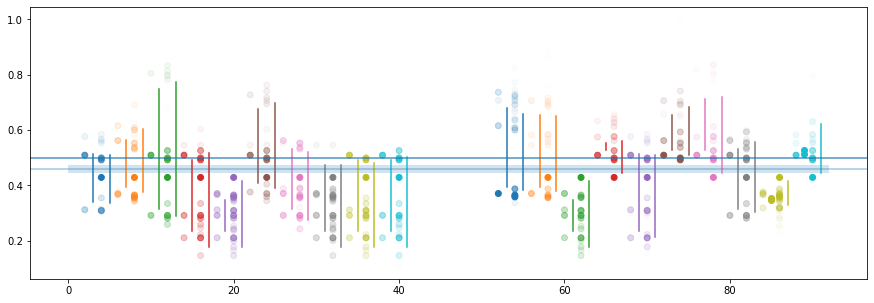

In [11]:
vis(filter_data_df_src, filter_data_df_test, 10, 2)

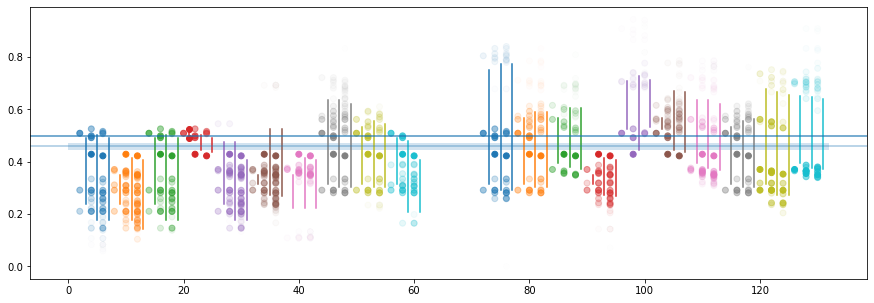

In [12]:
vis(filter_data_df_src, filter_data_df_test, 10, 3)

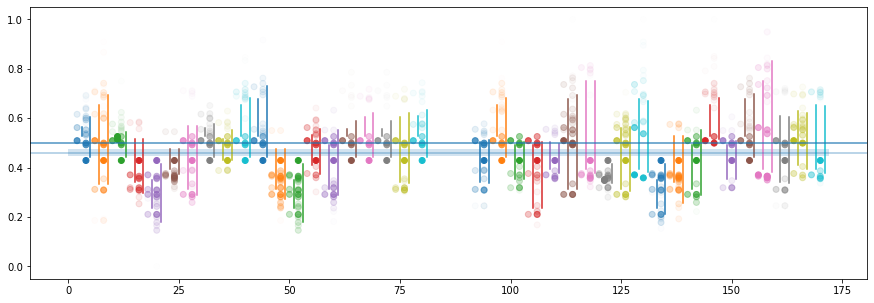

In [13]:
vis(filter_data_df_src, filter_data_df_test, 20, 2)

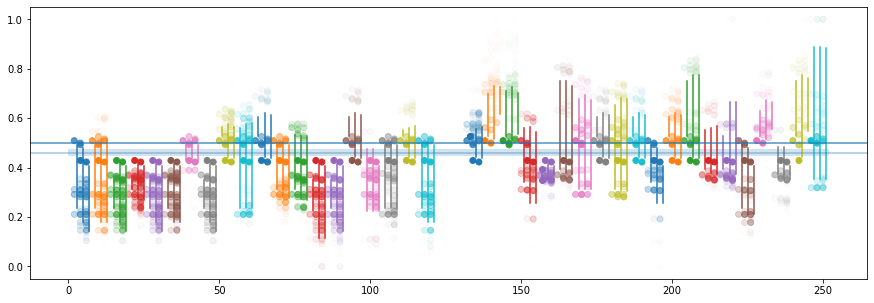

In [14]:
vis(filter_data_df_src, filter_data_df_test, 20, 3)

KeyboardInterrupt: 

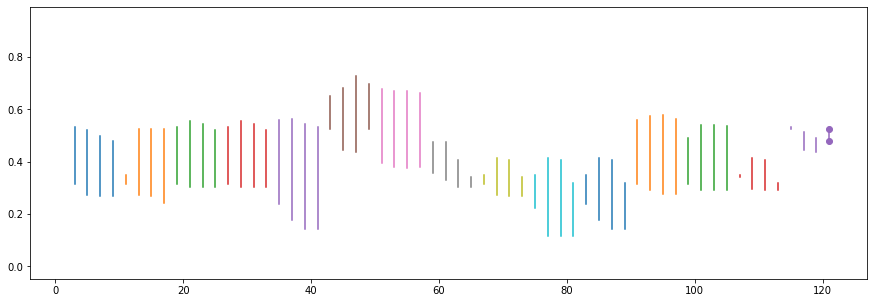

In [32]:
vis(filter_data_df_src, filter_data_df_test, 20, 4)

# Calculate rationalization for ALL test set samples

In [19]:
# Calculate rationalization for all test set samples

count_factors = 2

test_rationalizations = pd.DataFrame()

for _, case in filter_data_df_test.iterrows():
    for numfields in range(1, count_factors+1):
        test_rationalizations = pd.concat(
            [
                test_rationalizations,
                rationalize(case, filter_data_df_src, numfields=numfields),
            ],
            ignore_index=True,
        )

test_rationalizations[:20]

,id,field_count,fields,sample_size,percent_recid,percent_recid_alt,conf_95_bot,conf_95_top,significant_baseline,significant_altgroup
0,9.0,1.0,[age],72.0,0.388889,0.460637,0.276155,0.511063,0.0,0.0
1,9.0,1.0,[age_cat],2811.0,0.475987,0.437912,0.457380,0.494644,0.0,0.0
2,9.0,1.0,[juv_fel_count],4768.0,0.450503,0.715976,0.436310,0.464757,0.0,1.0
3,9.0,1.0,[decile_score],536.0,0.453358,0.460350,0.410639,0.496594,0.0,0.0
4,9.0,1.0,[juv_misd_count],4653.0,0.443370,0.725352,0.429028,0.457783,0.0,1.0
5,9.0,1.0,[juv_other_count],4571.0,0.438416,0.724044,0.423965,0.452945,0.0,1.0
6,9.0,1.0,[priors_count],373.0,0.554960,0.451797,0.502918,0.606122,1.0,1.0
7,9.0,1.0,[c_charge_degree],3170.0,0.509148,0.370685,0.491586,0.526693,1.0,1.0
8,9.0,1.0,[c_charge_desc],634.0,0.457413,0.459912,0.418122,0.497102,0.0,0.0
9,9.0,2.0,"[age, age_cat]",72.0,0.388889,0.460637,0.276155,0.511063,0.0,0.0


In [22]:
# Calculate confidence interval of entire training dataset
breakdown = filter_data_df_src[trueresult_field]
src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta')
src_range

(0.4456153737635861, 0.4736141374627171)

# Show distribution of confidence interval gaps

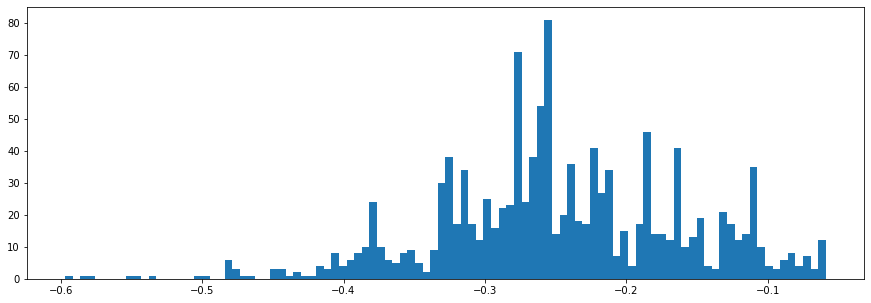

In [35]:
# Compute and show confidence interval gaps between "best to justify 1" vs "best to justify 0"
temp_gaps = []
for x_id, x_rat in test_rationalizations.groupby(['id']):
    range_lo = max(x_rat['conf_95_bot'])
    range_hi = min(x_rat['conf_95_top'])
    temp_gaps.append(range_hi-range_lo)

import matplotlib.pyplot as plt
import numpy as np

_ = plt.hist(temp_gaps, bins=100)

plt.show() 